In [1]:
%load_ext autoreload
%autoreload 

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import preprocessDefinition
import importlib
!pip install -q -U keras-tuner
import kerastuner as kt
importlib.reload(preprocessDefinition)
from preprocessDefinition import preprocess
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.decomposition import PCA

     |████████████████████████████████| 71kB 7.2MB/s 


In [4]:
dataset, info = tfds.load("oxford_flowers102", with_info=True, as_supervised=True)
dataset

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteL2HPE2/oxford_flowers102-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteL2HPE2/oxford_flowers102-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteL2HPE2/oxford_flowers102-validation.tfrecord


Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


{'test': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'train': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'validation': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>}

In [5]:
info.features

FeaturesDict({
    'file_name': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
})

In [6]:
class_names = info.features["label"].names
class_names

['pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold',
 'tiger lily',
 'moon orchid',
 'bird of paradise',
 'monkshood',
 'globe thistle',
 'snapdragon',
 "colt's foot",
 'king protea',
 'spear thistle',
 'yellow iris',
 'globe-flower',
 'purple coneflower',
 'peruvian lily',
 'balloon flower',
 'giant white arum lily',
 'fire lily',
 'pincushion flower',
 'fritillary',
 'red ginger',
 'grape hyacinth',
 'corn poppy',
 'prince of wales feathers',
 'stemless gentian',
 'artichoke',
 'sweet william',
 'carnation',
 'garden phlox',
 'love in the mist',
 'mexican aster',
 'alpine sea holly',
 'ruby-lipped cattleya',
 'cape flower',
 'great masterwort',
 'siam tulip',
 'lenten rose',
 'barbeton daisy',
 'daffodil',
 'sword lily',
 'poinsettia',
 'bolero deep blue',
 'wallflower',
 'marigold',
 'buttercup',
 'oxeye daisy',
 'common dandelion',
 'petunia',
 'wild pansy',
 'primula',
 'sunflower',
 'pelargonium',
 'bishop of llandaff',
 'gaura',

In [7]:
n_classes = info.features['label'].num_classes
n_classes

102

In [8]:
dataset_size = info.splits['train'].num_examples
dataset_size

1020

In [9]:
train_set   = tfds.load('oxford_flowers102', split='train', as_supervised=True)
val_set     = tfds.load('oxford_flowers102', split='validation', as_supervised=True)
test_set     = tfds.load('oxford_flowers102', split='test', as_supervised=True)

In [10]:
batch_size = 32
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [11]:
base_model = keras.applications.efficientnet.EfficientNetB0(
        weights = "imagenet",
        include_top = False)

16711680/16705208 [==============================] - 0s 0us/step


In [12]:
# for layer in base_model.layers:
#     layer.trainable = False

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(
    units = n_classes, 
    activation = "softmax")(avg)

model = keras.models.Model(
    inputs = base_model.input,
    outputs = output)

X2D = model.predict(test_set)

In [13]:
pca = PCA()
pca.fit(X2D)
var = pca.explained_variance_ratio_
var.cumsum()

array([0.08792318, 0.15082693, 0.21089353, 0.2669762 , 0.3078853 ,
       0.3437987 , 0.37777558, 0.4087171 , 0.43781647, 0.46307713,
       0.4867224 , 0.5096968 , 0.529405  , 0.5480368 , 0.5661707 ,
       0.58180517, 0.5970042 , 0.61128217, 0.6252624 , 0.6385388 ,
       0.65121543, 0.663521  , 0.6755129 , 0.6866594 , 0.69738746,
       0.70780194, 0.71745324, 0.726939  , 0.73607105, 0.744732  ,
       0.7532388 , 0.76145196, 0.76941514, 0.7770963 , 0.78457737,
       0.7917969 , 0.798437  , 0.8050049 , 0.8113662 , 0.8176436 ,
       0.82377803, 0.8298694 , 0.835519  , 0.84104675, 0.8465421 ,
       0.8519035 , 0.85702556, 0.86198896, 0.86691296, 0.871751  ,
       0.87646496, 0.88103527, 0.8854411 , 0.88969415, 0.8938783 ,
       0.89798796, 0.9019554 , 0.9058254 , 0.90956336, 0.9132667 ,
       0.9168584 , 0.92030364, 0.9236818 , 0.92699456, 0.93020916,
       0.93332577, 0.9363562 , 0.9393132 , 0.9422301 , 0.9450191 ,
       0.9477647 , 0.9504274 , 0.9530004 , 0.95550334, 0.95790

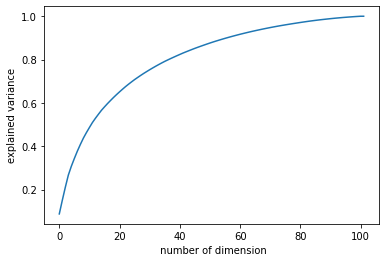

In [14]:
plt.plot(var.cumsum())

plt.xlabel(" number of dimension")
plt.ylabel("explained variance")
plt.savefig("explainedVariancePlot.png")

plt.show()